<a href="https://colab.research.google.com/github/SiddSai/Learning-PyTorch/blob/main/DeepLearningWithPytorch_simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Convolutional Neural Network:


*   Image Kernal/Filter (Matrix) --> change ones and zeros with filter matrix
*   CNN will do this over the entire matrix
*   Convolution = process of dragging (striding) over entire
*   In ANN neurons are fully connected
*   In CNN neurons are not fully connected (locally connected)
*   Color imaging = different filtering process
*   Color = 3d tensors
*   After running through this process, we will run through fully collected layer as well
*   Pooling Layer: Takes inputs from convolutional layer and pools them and reduces them
*   Reduce parameters with pooling layer (even when using convolutional layer it is a lot of inputs) --> downsampling
*   You lose information but trend stays the same
*   Max pooling: take max --> reduce
*   Avg Pooling: take avg --> reduce




In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# While black/white images are 2 dimensional, but we need a tensor of 4 dimensions
# Keep track of the number of images, height, width, color channel

# Conver MNIST Image Files into a Tensor of 4-Dimensions (# of images, Height, Width, Colr Channel)
transform = transforms.ToTensor()

In [4]:
# Train Data
train_data = datasets.MNIST(root = '/cnn_data', train = True, download = True, transform = transform)


100%|██████████| 9.91M/9.91M [00:00<00:00, 38.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.11MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


In [5]:
# Test Data

test_data = datasets.MNIST(root = '/cnn_data', train = False, download = True, transform = transform)


In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
# Create a small batch size for images
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [9]:
# Define CNN Model
# Describe convolutional layer and what it is doing (2)

conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)


In [10]:
# Grab 1 mnist record

for i, (X_Train, y_train) in enumerate(train_data):
  break

In [11]:
X_Train.shape

torch.Size([1, 28, 28])

In [12]:
x = X_Train.view(1, 1, 28, 28)

In [13]:
# Perform first convolution

x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function


In [14]:
# 1 single image, 6 are the filters we asked for, 26x26 is the image (because we set no padding)
x.shape

torch.Size([1, 6, 26, 26])

In [15]:
# pass through our poolin layer

x = F.max_pool2d(x, 2, 2) # kernal of 2 and slide of 2

In [16]:
# 1 single image, 6 are the filters we asked for, shrinking by 2 for poolin (26/2 = 13)
x.shape

torch.Size([1, 6, 13, 13])

In [17]:
# Second convolutional layer
x = F.relu(conv2(x))

In [18]:
x.shape # No padding again, so we lost 2 pixels on outside of the image

torch.Size([1, 16, 11, 11])

In [19]:
# Pooling layer
x = F.max_pool2d(x, 2, 2)

In [20]:
x.shape # 11/2 = 5.5, but we round down (we can't invent data to round up)

torch.Size([1, 16, 5, 5])

In [21]:
# Now we have established what the model actually does during every epoch

In [22]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)

    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)



  def forward(self, X):
    # Forward function

    # First pass
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernal and a stride of 2

    # Second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernal and a stride of 2

    # Re-View data to flatten it out
    X = X.view(-1, 16*5*5) # set to negative one so that we can vary the batch size

    # Full connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim = 1)



In [23]:
# Create instanc of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [24]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # Smaller learning rate = longer train but better model

In [26]:
import time
start_time = time.time()

# Create Variables to Track
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


# For loop for iterating through epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b += 1 # start our batches at 1
    y_pred = model(X_train) # get our predicted values from training set (not flat, it's 2d)
    loss = criterion(y_pred, y_train) # Compare predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # total number of correct predictions
    batch_corr = (predicted == y_train).sum() # how many we got correct in this batch
    trn_corr += batch_corr # keep track of our num of correct throuhout training


    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): # No gradient so we do not update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Count correct predictions
      tst_corr += (predicted == y_test).sum() # T = 1, F = 0 --> sum up


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()
total_time = current_time - start_time
print(f'Time to Train: {total_time/60} minutes')


Epoch: 0  Batch: 600  Loss: 0.003126084106042981
Epoch: 0  Batch: 1200  Loss: 0.3031778931617737
Epoch: 0  Batch: 1800  Loss: 0.0024100872687995434
Epoch: 0  Batch: 2400  Loss: 0.0018737802747637033
Epoch: 0  Batch: 3000  Loss: 0.0162246972322464
Epoch: 0  Batch: 3600  Loss: 0.37820178270339966
Epoch: 0  Batch: 4200  Loss: 0.02532477118074894
Epoch: 0  Batch: 4800  Loss: 0.0012947404757142067
Epoch: 0  Batch: 5400  Loss: 0.0008680702303536236
Epoch: 0  Batch: 6000  Loss: 0.3670758008956909
Epoch: 1  Batch: 600  Loss: 0.037437085062265396
Epoch: 1  Batch: 1200  Loss: 0.00439482694491744
Epoch: 1  Batch: 1800  Loss: 0.0009367108577862382
Epoch: 1  Batch: 2400  Loss: 0.003446018323302269
Epoch: 1  Batch: 3000  Loss: 0.01587623916566372
Epoch: 1  Batch: 3600  Loss: 0.001758426078595221
Epoch: 1  Batch: 4200  Loss: 0.0921141654253006
Epoch: 1  Batch: 4800  Loss: 0.0007350038504227996
Epoch: 1  Batch: 5400  Loss: 0.03130321204662323
Epoch: 1  Batch: 6000  Loss: 0.19755962491035461
Epoch: 2  

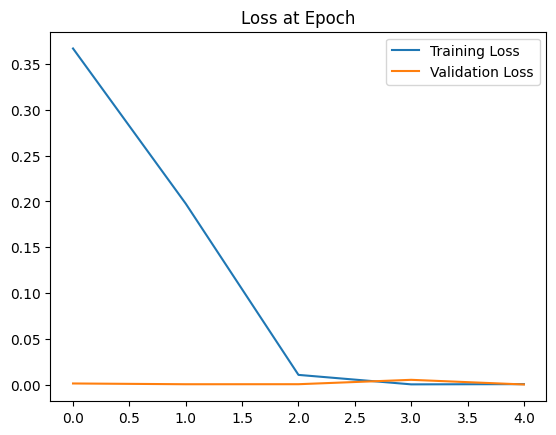

In [35]:
# Visuallizing CNN results

# Graph loss at epoch
#train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label = "Training Loss")
plt.plot(test_losses, label = "Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

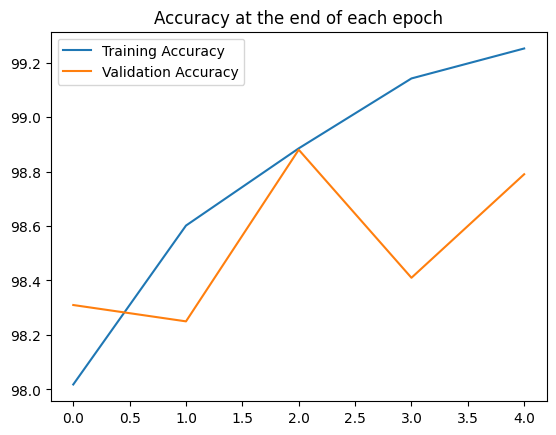

In [41]:
# Graph accuracy at the end of each epoch


plt.plot([t/600 for t in train_correct], label = "Training Accuracy")
plt.plot([t/100 for t in test_correct], label = "Validation Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [42]:
test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [44]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_all:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [47]:
# Check for correct
correct.item()/len(test_data)

0.9879

In [49]:
# Grab image
test_data[4143] # Provides tensor with image in it

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [51]:
# Grab just the tensor
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [53]:
# Reshape it
test_data[4143][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

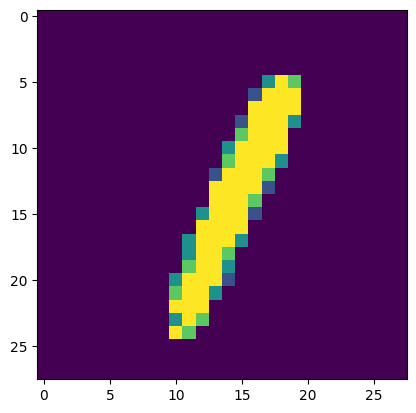

In [64]:
plt.imshow(test_data[9836][0].reshape(28, 28))

In [66]:
# Pass images throught the model
model.eval()

with torch.no_grad():
  new_pred = model(test_data[9836][0].view(1, 1, 28, 28)) # batch size of 1, 1 color channel, 28x28 image


In [67]:
# Check the new prediction --> give probablities
new_pred

tensor([[-1.8358e+01, -7.1526e-07, -2.2804e+01, -2.7810e+01, -1.5801e+01,
         -2.0043e+01, -1.6705e+01, -1.4784e+01, -1.8839e+01, -1.6073e+01]])

In [68]:
new_pred.argmax()

tensor(1)